# AM207 Final Project

**Team:** Hari Kothapalli and Roshan Padaki

**Paper:** Subspace Inference for Bayesian Deep Learning

**What is the point of this paper and why is it important/interesting?**

With the rise of deep neural networks, it has become infeasible to directly apply many Bayesian inference methods to large networks. Given the dimensionality of the weight space in these increasingly large network architectures, it is difficult to find techniques that a) learn within a reasonable timeframe and b) produce viable results which capture useful measures of uncertainty. This paper presents a potential solution to this problem, by proposing the construction of so-called "subspaces" of the network parameter space. Performing inference in these low-dimensional subspaces is quite feasible for off-the-shelf methods such as BBVI, ESS, etc. and turns out to generalize well to a variety of common network architectures and machine learning problems. 

**What has already been done in literature and what does this paper contribute (technically)?**

In literature, there are already several methods which attempt to solve this problem for deep Bayesian learning. One particularly compelling attempt is SWAG, proposed by Maddox et al. which uses SGD trajectory iterates to find paramters for approximate Gaussian posteriors over the network weights. This turns out to be the motivation for the PCA subspace technique proposed in this paper, which uses the principal components of the SGD iterates to create a low-dimenstional subspace, in which inference is performed directly.

Another paper, by Pradier et al., attempts to form a subspace using an auto-encoder. But as the authors of this paper point out, that technique is way too expensive and therefore unscalable since it involves first training several methods to perform ensembling and *then* also training an auto-encoder. The important similiarity between that work and this paper is that both propose using variational inference in the subspace.

Motivating this paper's idea to perfrom inference in a curve subspace is prior work by Garipov et al., which affirms that the "mountain pass" between two modes in the parameter space is generally an area of low-loss. The authors realize that such a subspace contains a lot of *diverse* and pretty decent models, which is exactly what is necessary to generate a Bayesian model that exhibits "good uncertainty." They use a curve between two SGD solutions, making this their most expensive method, since it requires two unconstrained optimization passes before inference within the subspace.

Several other techniques are also, but none of them use the idea of generating the subspace based on features of the parameter space as discovered through unconstrained optimization. Still other similar techniques attempt to optimize inference, but work within the *data space* rather than the parameter space. This paper cleverly builds upon the idea of performing variational inference within a subpace, extends this to MCMC samplers such as ESS, which they show to be particularly effective, and importantly first employs unconstrained optimization (SGD) to help generate meaningful subspaces in the parameter space. 

The key takeaway with respect to this contribution of this paper is generalizeability and modularity. Because of their approach, the authors are able to use a wide variety of off-the-shelf approximate inference methods. Moreover, the methods by which they construct their subspaces are relatively straightforward and can be adapted to work on any model. This means that the results of this paper, as the authors show to some degree, can work on a lot of different network architectures and applications!

**What are the important technical details?**

*   *Subspace Model*
> The paper defines a $K$-dimensional subspace as follows: 
<br/><br/> $$ \begin{aligned} S &= \{w|w = \hat{w} + z_1v_1 + ... + z_Kv_K\}\\ &= \{w|w = \hat{w} + Pz\}, \end{aligned}$$ 
<br/> where $\hat{w}$ is a fixed shift vector, $P = (v_1^T,...,v_K^T)$ is the projection matrix, $z = (z_1,...,z_K)^T$ are the free parameters (i.e. what we perform inference on). Essentially, what this means is that we perform inference in some low-dimension ($K$) over $z$, and then we project back into the dimension ($d$) of the weights of our actual model. The shift vector $\hat{w}$ provides a reasonable centering for our subspace. As is proposed in the paper, we can typically find this via SGD on the whole network parameter space.
<br/><br/> Thus, instead of using the typical likelihood function for the model, which would be $p(D|w)$, we end up with the following: <br/><br/> $$ \begin{aligned} p(D|w) &= p(D|\hat{w} + Pz)\\ &= p(D|z) \end{aligned} $$
<br/> We are then interested in approximating the posterior $p(z|D)$, in order to perform Bayesian model averaging. The key insight here is that this is much easier to do than in the subspace than in the full parameter space, where the posterior would be $p(w|D)$. This opens up the possiblity to choose from a wide-range of inference methods, including the MCMC methods we saw in class.

*   *Subspace Construction*
> The authors present several methods by which they construct low-dimensional subspaces of the weight space. <br/><br/>
The first is random. To construct this subspace, the projection matrix, $P$ consists of entirely random $v_i$, each of unit norm. The shift vector, $\hat{w}$, is found via stochastic weight averaging, which simply involves taking averages over SGD iterates. Evidently, this subspace is easy to construct, since it merely involves sampling random numbers. Coversely, it also has the worst performance, since it enocdes no specific information about the model. Thus it fails to "contain a diverse set of models that produce meaningfully different predictions." Intuitively, we might imagine that only the models at the center of the subspace, i.e. close to the shift vector (which is a pre-trained solution), produce good predictions, but that is not a diverse set of models! <br/><br/>
The second method is PCA over the SGD trajectory. This approach attempts to remedy the problem mentioned above, while still remaining inexpensive to construct. Again, the subspace is centered on the stochastic weight averaging solution, $\hat{w} = w_{SWA}$. The projection matrix, however, is constructed using Principal Component Analysis. To do this, we create a matrix $A$, where $a_i = w_i - w_{SWA}$, i.e. the deviation from pre-trained solution on iteration $i$ (note that we do not actually have a vector for each iteration, instead we might sample every $n$th iteration and also set a finite number of deviations to store). From this matrix $A$ consisting of deviation vectors, we put the first $K$ principal components into our projection matrix, $P$. This methodology predicates on the idea most of the SGD updates themselves occur within a low-dimensional subspace of the parameter space, which turns out to be empirically true in general!<br/><br/>
The final and perhaps most interesting method is curve subspace construction. The curve subspace tends to be produce the highest performing but is also the most expensive to construct. At an intuitive level, we can think of the curve subspace as the line connecting two modes in the parameter space. If we imagine this in 3D space for example, we might understand it as a "mountain pass" of sorts connecting two peaks. Regardless of the dimensionality of the weight space, this subspace is always 2-dimensional. To find the two candidate modes, we run SGD from two different random initializations. We then parameterize the curve using 
$$\begin{aligned}\hat{w} &= (w_1 + w_0)/2\\ v_1 &= (w_0 − \hat{w})/|w_0 − \hat{w}|\\ v_2 &= (w_{1/2} − \hat{w})/|w_{1/2} − \hat{w}|,\end{aligned}$$ where $w_0$ and $w_1$ are the endpoints, and $w_{1/2}$ is the midpoint of the curve -- and as before, $P = (v_1^T, v_2^T)$. A particular nuance of this subspace is that a Gaussian approximation from the posterior becomes relatively unreasonable, which can create problems with certain samplers for example, as we'll touch on later.


*   *Inference Methods*
> To perfrom inference within the subspace, the authors employ four main methods to approximately sample from the posterior, $p(z|D)$: No-U-Turn-Sampler (NUTS), Elliptical Slice Sampling (ESS), Variational Inference with fully factorized Gaussian approximation family (VI), and Real-valued Non-Volume Preserving flow (RealNVP). Note that the details of these techniques are not particularly important -- a range of many other inference procedures could be used as well. What is important, however, is that *some of the assumptions made by the variational methods can fall apart*; for example, the VI technique assumes the posterior is a Gaussian and therefore can fail to produce a strong fit of the data, particularly in the curve subspace where the shape of the posterior can be quite complex. It is cool to see that dimensionality reduction through subspace construction allows familiar MCMC methods to be used. We used NUTS (from PyMC3) during a few homeworks in class; the paper also mentions HMC and Metropolis Hastings as potential candidates, both of which we discussed in class.



**What do the experiments (attempt to) prove and are they valid?**

Through their experiments, the authors want to show that their subspace inference technique produces a) good results on regression and classification results and b) strong "predictive uncertainty" on regression tasks. To that end, they begin with toy examples on 400 randomly sampled points in 2D space. With these examples, it is easy to visualize the predictive distribution against the actual data (we begin our own implementation below by attempting to recreate these visualizations from scratch). They use a standard fully-connected deep NN architecture with four hidden layers consisting of 200, 50, 50, and 50 neurons respectively. 

The authors present predictive plots for every combination of their three subspace types and four selected inference methods, which they compare to selected methods from previous literature. The SWAG method from Maddox et al. appears to produce extremely similar to those from this paper. Among those from this paper, ESS appears to be the best inference technique and produces "good" predictive uncertainty results on both the PCA and curve subspaces.

While the authors seem to be extremely satisfied with their exposition of regression uncertainty results, it remains unclear how to characterize what exactly is good epsitemic/predictive uncertainty. Intuititively, we want our models 1) to have a reasonable fit of the training data and 2) to not be overly confident in regions where we don't have much data to work with. These two criteria motivate the authors general claim that predictive uncertainty is desireable. However, we contend that their judgement of what constitutes the "best" predictive uncertainty may be a bit arbitrary. There really is no "best" balance between extrapolation, data fit, and epistemic uncertainty; there are good reasons for different models to have varying degress of each. Thus, we must criticize, to some extent, the paper's rather qualitative and opiniated approach to categorizing uncertainty. Strong future work would wrestle more concretely with the concept of "good" predictive uncertainty and attempt to define -- application specific, perhaps -- metrics on which to compare different models.

The authors then go on to much larger datasets, performing regression on the UCI dataset and classification on the CIFAR dataset. The UCI regression test appears to be fairly straightforward and standard comparison. The authors choose recent techniques for performing approximate Bayesian inference on neural networks and utilize the experimental framework from pre-exisiting literature. Log-likelihood is a reasonable metric here becuase higher values indicate that we capture the data well (low aleatoric uncertainty). The subpace inference method produce quite strong results across datasets and, importantly, consistently outperforms the SGD baseline.
 
Image classification on CIFAR tells a similarly positive story. Again, the use of a common open dataset makes the results easy to compare with other models.  Subspace inference (using the PCA subspace, which provides the best perfomance to computational complexity tradeoff) almost always perform as well or better than a range of other modern techniques. Equally interesting is the comparison between different subspace types. As expected, the curve subspace produces the best results (as measured by NLL and classification accuracy), followed by the PCA subpace, and then the random subspace. This hierarchy corrorabates the rationale behind each of the subspaces, with the curve subspace encoding the most useful information about the parameter space, followed by the PCA subspace, and then the random subspace (which has very little such information).

Thus, as far as quantitative results are concerned, the experimental design and conclusion are sound. The use of a variety of common datasets gives us a fair amount of confidence about the generalizeability of these results to real tasks. **Moreover, we were able to reproduce many of their claims below, using our own implementation -- lending credence to the validity/practicality of their approach**. As aforementioned, we take issue with the overly hand-wavy approach to defining "good" predictive uncertainty, although this presents an area for future work. Overall, the experimental section seems to confirm the efficacy of subspace inference across a variety of neural network architectures and applications, especially when compared to existing approximate BNN inference methods.

**What can be done to improve or build on this work?**

As mentioned above, a difficult but extremely useful area of future work would be to derive metrics to measure uncertainty; this would permit more concrete model comparison and would be an extremely important contribution to the field, since a hallmark of Bayesian inference is being able to simeoultaneously produce good predictions/data fit while also providing epistemic uncertainty away from the data.

A more specific area of future work for the paper involves experimenting with different inference methods within the subspace; this is the easiest change to make, since in theory almost any inference technique will work with this setup. This is motivated by the fact that different inference techniques make different underlying assumptions, which may or not be well-suited to a given subspace type. For example, as is noted in the paper, the simple variational approaches, which represents the posterior as a Gaussian, fails in the curve subspace, where the shpae of the posterior is quite complex.

Another related area of work would entail reserching alternative methods of subspace construction.

# Import Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import time
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.convert_parameters import _check_param_device
from matplotlib import pyplot as plt
from tqdm import trange
import seaborn as sns

# Data Setup

We setup our pedagogical example using some randomly generated toy data:

In [ ]:
class ToyDataset(Dataset):
    def __init__(self, x_data, y_data):
        assert (len(x_data) == len(y_data)), \
            "Error: x and y data must be of the same length!"
        self.length = len(x_data)
        self.x_data = x_data
        self.y_data = y_data
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return {
            'src': self.x_data[idx].reshape(1, -1),
            'trg': self.y_data[idx].reshape(1, -1)
        }

In [ ]:
data = np.load("data.npy")
x, y = data[:, 0], data[:, 1]
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])
f = features(x)

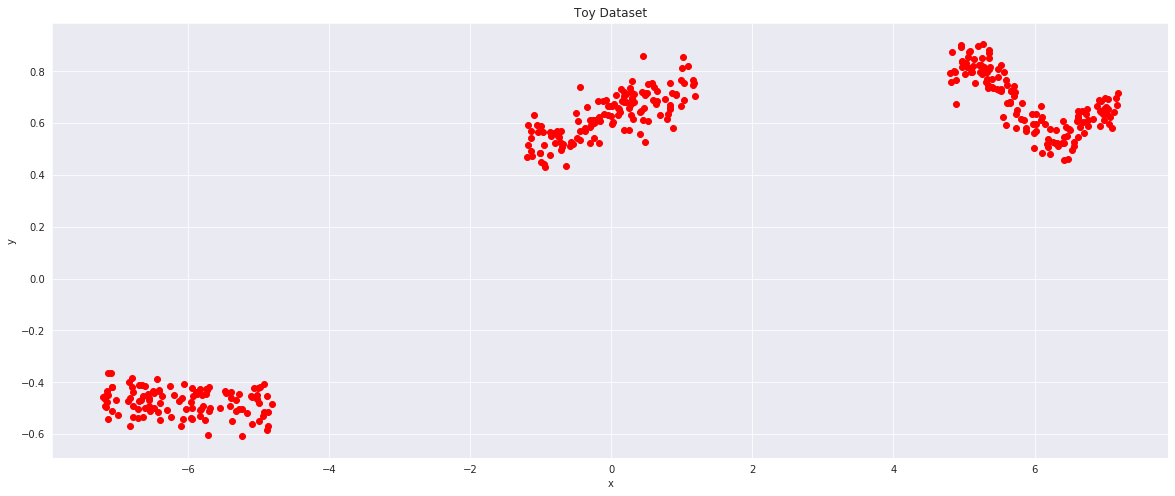

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("Toy Dataset")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y, color='red')
plt.show()

In [ ]:
toy_dataset = ToyDataset(f.astype(np.float32), y.astype(np.float32))
splits = [int(0.8 * len(x)), len(x) - int(0.8 * ( len(x)))]
train_split, val_split = random_split(toy_dataset, splits)
trian_split = toy_dataset
train_iter = DataLoader(train_split, batch_size=50, shuffle=True)
val_iter = DataLoader(val_split, batch_size=50, shuffle=True)

# Model Setup

Here we define/implement our selected neural network architectures as well as the curve subspace construction method:

In [ ]:
def get_weights(params):
    return nn.utils.parameters_to_vector(params)

def set_weights(params, w):
    nn.utils.vector_to_parameters(w, params)

def set_frozen_weights(model, w):
    if not isinstance(w, torch.Tensor):
        raise TypeError('expected torch.Tensor, but got: {}'
                        .format(torch.typename(w)))
    param_device = None
    pointer = 0
    for module in model.modules():
        for name in list(module._frozen_params.keys()):
            if module._frozen_params[name] is None:
                continue
            param = module._frozen_params[name]
            param_device = _check_param_device(param, param_device)
            num_param = param.numel()

            module._frozen_params.pop(name)
            param = w[pointer:pointer + num_param].view_as(param)
            pointer += num_param
            setattr(module, name, param)
            module._frozen_params[name] = param

def freeze_parameters(model):
    for module in model.modules():
        module._frozen_params = OrderedDict({})
        for name in list(module._parameters.keys()):	
            if module._parameters[name] is None:	
                continue
            param_data = module._parameters[name].data
            module._parameters.pop(name)
            setattr(module, name, param_data)
            module._frozen_params[name] = param_data

In [ ]:
class MLP(nn.Module):
    def __init__(self, d_input, d_hidden, d_output, n_layers):
        super().__init__()
        self.readin = nn.Linear(d_input, d_hidden)
        self.layers = nn.ModuleList([nn.Linear(d_hidden, d_hidden) for _ 
                                     in range(n_layers-2)])
        self.readout = nn.Linear(d_hidden, d_output)

    def forward(self, x):
        x = self.readin(x).relu()
        for layer in self.layers:
            x = layer(x).relu()
        return self.readout(x)

In [ ]:
class Curve(nn.Module):
    def __init__(self, start_weights, end_weights):
        super().__init__()
        self.register_buffer('start', start_weights)
        self.register_buffer('end', end_weights)
    
    def sample_uniform(self, *shape):
        t = torch.rand(size=shape, device=self.start.device)
        return self.forward(t)

class QuadraticBezierCurve(Curve):
    def __init__(self, start_weights, end_weights):
        super().__init__(start_weights, end_weights)
        self.theta = nn.Parameter(torch.randn(*self.start.shape, 
                                              device=self.start.device))

    def forward(self, t):
        return (1-t)**2 * self.start + 2*t*(1-t) * self.theta + t**2 * self.end 


class CurveSubspace(nn.Module):
    def __init__(self, model, curve):
        super().__init__()
        self.model = model
        freeze_parameters(self.model)
        self.curve = curve
    
    def forward(self, *args, **kwargs):
        weights = curve.sample_uniform()
        set_frozen_weights(self.model, weights)
        return self.model(*args, **kwargs)
    
    def get_projection(self):
        self.curve.eval()
        with torch.no_grad():
            w_start = self.curve(0.)
            w_end = self.curve(1.)
            w_mid = self.curve(0.5)
            w_hat = (w_start + w_end) / 2.
            v1 = w_start - w_hat
            v1 = v1 / v1.norm()
            v2 = w_mid - w_hat
            v2 = v2 / v2.norm()
            proj_matrix = torch.stack((v1, v2))
            return w_hat, proj_matrix

In [ ]:
class VIModel(nn.Module):
    def __init__(self, base, w_hat, proj_matrix, init_inv_softplus_sigma=-3.0, 
                 n_samples=100, prior_log_sigma=3.0, eps=1e-6, device=None):
        super().__init__()

        self.base_model = base
        freeze_parameters(self.base_model)

        self.register_buffer('w_hat', w_hat)
        self.register_buffer('proj_matrix', proj_matrix)
        rank = self.proj_matrix.shape[0]

        self.n_samples = n_samples
        self.prior_log_sigma = prior_log_sigma
        self.eps = eps
        self.mu = torch.nn.Parameter(torch.zeros(rank))
        self.inv_softplus_sigma = torch.nn.Parameter(
            torch.ones(rank) * init_inv_softplus_sigma
        )
        self.to(device)
    
    def get_sigma(self):
        return nn.functional.softplus(self.inv_softplus_sigma) + self.eps

    def forward(self, *args, **kwargs):
        sigma = self.get_sigma()
        out = 0.
        for _ in range(self.n_samples):
            z = self.mu + torch.randn_like(sigma) * sigma
            w = self.w_hat + z @ self.proj_matrix
            set_frozen_weights(self.base_model, w)
            out += self.base_model(*args, **kwargs)
        return out / self.n_samples

    def compute_kl(self):
        sigma = self.get_sigma()
        mean_square_weight = (sigma**2 + self.mu**2).sum()
        square_sigma_prior = np.exp(self.prior_log_sigma * 2)
        kl = -sigma.log().sum() + mean_square_weight/(2 * square_sigma_prior)
        kl += self.prior_log_sigma
        return kl

    def compute_entropy(self):
        return self.get_sigma().log().sum()        

class ELBO():
    def __init__(self, model, criterion, num_samples,
                 out_precision=0.5, temperature=1.):
        self.model = model
        self.criterion = criterion
        self.num_samples = num_samples
        self.out_precision = out_precision
        self.temperature = temperature

    def __call__(self, input, target):
        loss = self.criterion(input, target)
        kl = self.model.compute_kl() / self.num_samples
        return 0.5 * loss / self.out_precision ** 2 + kl * self.temperature

# Training Setup

In [ ]:
def init_weights(model, *args, init_fn_=nn.init.normal_, **kwargs):
    for p in model.parameters():
        init_fn_(p, *args, **kwargs)

In [ ]:
def train_epoch(model, train_iter, optimizer, criterion, device=None, src_key='src', trg_key='trg'):
    epoch_loss = 0
    model.train()

    for batch in train_iter:
        src = batch[src_key].to(device)
        trg = batch[trg_key].to(device)
        optimizer.zero_grad()
        loss = criterion(model(src), trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_iter)

def eval(model, val_iter, criterion, device=None, src_key='src', trg_key='trg'):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for batch in val_iter:
            src = batch[src_key].to(device)
            trg = batch[trg_key].to(device)
            loss = criterion(model(src), trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(val_iter)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, train_iter, val_iter, optimizer, criterion, n_epochs,
          device=None, verbose=True, save_best=True, checkpoint_file="model.pt",
          keys=['src', 'trg']):
    model = model.to(device)
    loss_history = {'train': [], 'val': []}
    best_valid_loss = float('inf')
    if verbose:
        print(f"Training Model for {n_epochs} Epochs")
        print("--------------")
    if verbose:
        epochs = range(n_epochs)
    else:
        epochs = trange(n_epochs, position=0)

    for epoch in epochs:
        start_time = time.time()
        train_loss = train_epoch(model, train_iter, optimizer, criterion, device, *keys)
        val_loss = eval(model, val_iter, criterion, device, *keys)
        end_time = time.time()

        if save_best and val_loss < best_valid_loss:
            torch.save(model.state_dict(), checkpoint_file)
            best_valid_loss = val_loss
        loss_history['train'].append(train_loss)
        loss_history['val'].append(val_loss)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose:
            print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
            print(f"\tTrain Loss: {train_loss:8.4f}")
            print(f"\t Val. Loss: {val_loss:8.4f}")
            print("--------------")
    if save_best:
        if verbose:
            print(f"Loading model from {checkpoint_file} with "
                  f"best val. loss {best_valid_loss:8.4f}...")
        model.load_state_dict(torch.load(checkpoint_file))
    return loss_history

def snapshot_train(model, train_iter, optimizer, criterion, n_epochs,
                   snapshot_freq, snapshot_size, device=None, keys=['src', 'trg']):
    model = model.to(device)
    w_swa = get_weights(model.parameters())
    n_snapshots = 0
    snapshot = torch.tensor([], device=device)

    model.train()
    for _ in trange(n_epochs, position=0):
        for batch_idx, batch in enumerate(train_iter):
            optimizer.zero_grad()
            src = batch[keys[0]].to(device)
            trg = batch[keys[1]].to(device)
            loss = criterion(model(src), trg)
            loss.backward()
            optimizer.step()

            if (batch_idx+1) % snapshot_freq is 0:
                w_swa = (n_snapshots * w_swa + get_weights(model.parameters()))
                n_snapshots += 1
                w_swa = w_swa / (n_snapshots)
                if len(snapshot) == snapshot_size:
                    snapshot = snapshot[1:]
                delta = (get_weights(model.parameters()) - w_swa).unsqueeze(0)
                snapshot = torch.cat((snapshot, delta), 0)
    return w_swa, snapshot

# Visualization Setup

In [ ]:
def plot_predictive(trajectories, data, xs, mu=None, sigma=None, title=None):
    sns.set_style('darkgrid')
    palette = sns.color_palette('colorblind')
    
    blue = sns.color_palette()[0]
    red = sns.color_palette()[3]

    plt.figure(figsize=(20., 8.))
    
    x, y = data
    plt.scatter(x, y, color=red)
    
    if mu is None:
        mu = np.mean(trajectories, axis=0)
    if sigma is None:
        sigma = np.std(trajectories, axis=0)

    plt.plot(xs, mu, "-", lw=2., color=blue)
    plt.plot(xs, mu-3 * sigma, "-", lw=0.75, color=blue)
    plt.plot(xs, mu+3 * sigma, "-", lw=0.75, color=blue)
    np.random.shuffle(trajectories)
    for traj in trajectories[:10]:
        plt.plot(xs, traj, "-", alpha=.5, color=blue, lw=1.)
        
    plt.fill_between(xs, mu-3*sigma, mu+3*sigma, alpha=0.35, color=blue)

    plt.xlim([np.min(xs), np.max(xs)])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if title:
        plt.title(title, fontsize=16)

# SGD Test

This provides an example of the uncertainty that we hope to replicate. As we move away from the data there should be more epistemic uncertainty. Essentially we hope our Bayesian models can encapsulate uncertainty in those regions, similar to the way that different SGD trials might produce very different fits in those regions away from the data. This is why the paper employs language which states that a subspace contains many diverse and perfromant models.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP(2, 40, 1, 5).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [ ]:
model_weights = []
for i in range(5):
    init_weights(model, 0., 0.25)
    train(model, train_iter, val_iter, optimizer, criterion, 
          n_epochs=99, device=device, verbose=False)
    model_weights.append(get_weights(model.parameters()))

100%|██████████| 99/99 [00:03<00:00, 26.83it/s]


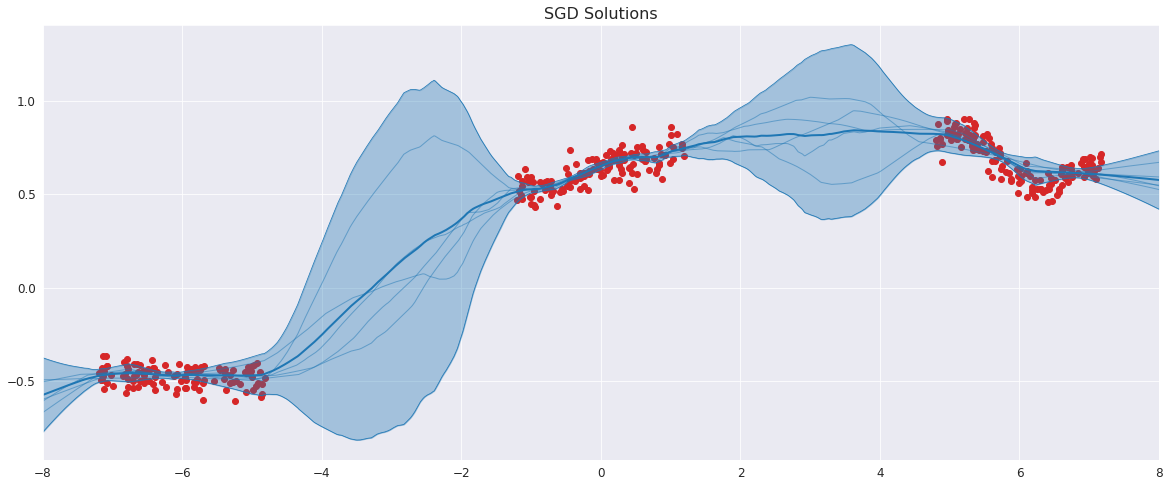

In [ ]:
trajectories = []
np_steps = np.linspace(-8., 8., 1000)
f_steps = features(np_steps)
inp = torch.from_numpy(f_steps.astype(np.float32)).to(device)

model.eval()
with torch.no_grad():
    for w in model_weights:
        set_weights(model.parameters(), w)
        out = model(inp).cpu().numpy().squeeze()
        trajectories.append(out)

trajectories = np.vstack(trajectories)
plot_predictive(trajectories, (x, y), np_steps, title="SGD Solutions")

# PCA + VI

In [ ]:
model = MLP(2, 40, 1, 5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
train(model, train_iter, val_iter, optimizer, criterion, 50, device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
w_swa, snapshot = snapshot_train(model, train_iter, optimizer, criterion, 50, 5, 600, device)

Training Model for 50 Epochs
--------------
Epoch: 01 | Time: 0m 0s
	Train Loss:   0.3873
	 Val. Loss:   0.3837
--------------
Epoch: 02 | Time: 0m 0s
	Train Loss:   0.3594
	 Val. Loss:   0.3518
--------------
Epoch: 03 | Time: 0m 0s
	Train Loss:   0.3250
	 Val. Loss:   0.3219
--------------
Epoch: 04 | Time: 0m 0s
	Train Loss:   0.3030
	 Val. Loss:   0.2943
--------------
Epoch: 05 | Time: 0m 0s
	Train Loss:   0.2831
	 Val. Loss:   0.2805
--------------
Epoch: 06 | Time: 0m 0s
	Train Loss:   0.2652
	 Val. Loss:   0.2658
--------------
Epoch: 07 | Time: 0m 0s
	Train Loss:   0.2457
	 Val. Loss:   0.2422
--------------
Epoch: 08 | Time: 0m 0s
	Train Loss:   0.2267
	 Val. Loss:   0.2235
--------------
Epoch: 09 | Time: 0m 0s
	Train Loss:   0.2078
	 Val. Loss:   0.2052
--------------
Epoch: 10 | Time: 0m 0s
	Train Loss:   0.1934
	 Val. Loss:   0.1872
--------------
Epoch: 11 | Time: 0m 0s
	Train Loss:   0.1771
	 Val. Loss:   0.1683
--------------
Epoch: 12 | Time: 0m 0s
	Train Loss:   0.15

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 44 | Time: 0m 0s
	Train Loss:   0.0161
	 Val. Loss:   0.0173
--------------
Epoch: 45 | Time: 0m 0s
	Train Loss:   0.0159
	 Val. Loss:   0.0163
--------------
Epoch: 46 | Time: 0m 0s
	Train Loss:   0.0155
	 Val. Loss:   0.0153
--------------
Epoch: 47 | Time: 0m 0s
	Train Loss:   0.0169
	 Val. Loss:   0.0159
--------------
Epoch: 48 | Time: 0m 0s
	Train Loss:   0.0155
	 Val. Loss:   0.0158
--------------
Epoch: 49 | Time: 0m 0s
	Train Loss:   0.0149
	 Val. Loss:   0.0151
--------------
Epoch: 50 | Time: 0m 0s
	Train Loss:   0.0151
	 Val. Loss:   0.0160
--------------
Loading model from model.pt with best val. loss   0.0151...


100%|██████████| 50/50 [00:01<00:00, 45.58it/s]


In [ ]:
with torch.no_grad():
    U, S, V = torch.svd(snapshot)
    proj_matrix = torch.diag(S).matmul(V.t())

In [ ]:
print(f"Initialized and partially trained model with {w_swa.size(0)} parameters.")
print("Dimension Importances")
for v in (S/S.sum()).detach().cpu().numpy()[:10]:
    print(f"{v*100.:5.2f}%")

Initialized and partially trained model with 5081 parameters.
Dimension Importances
75.05%
15.95%
 3.18%
 2.40%
 0.71%
 0.55%
 0.37%
 0.34%
 0.20%
 0.15%


In [ ]:
subspace_proj = proj_matrix[:10]
w_hat = w_swa.detach()

In [ ]:
init_sigma = 1.
prior_sigma = 5.
vi_model = VIModel(
    base = MLP(2, 40, 1, 5),
    w_hat = w_hat,
    proj_matrix = subspace_proj,
    init_inv_softplus_sigma = np.log(np.exp(init_sigma)-1),
    n_samples=5,
    prior_log_sigma = np.log(prior_sigma)
).to(device)

In [ ]:
elbo = ELBO(vi_model, criterion, len(train_split), temperature=1.5)
optimizer = torch.optim.Adam(vi_model.parameters())
lh = train(vi_model, train_iter, val_iter, optimizer, elbo, 1500, device, False, True, 'vi-model.pt')

100%|██████████| 1500/1500 [02:41<00:00, 10.11it/s]


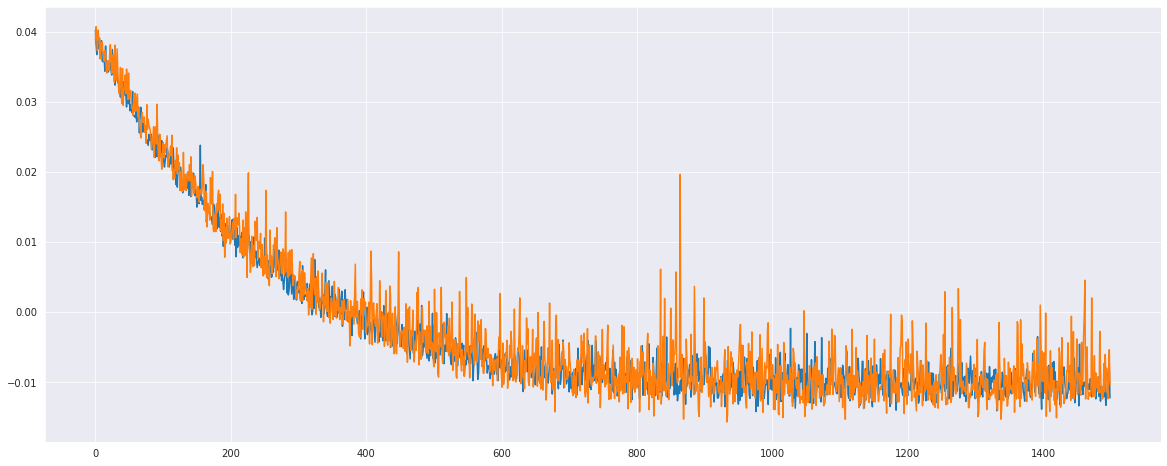

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(lh['train'])
plt.plot(lh['val'])
plt.show()

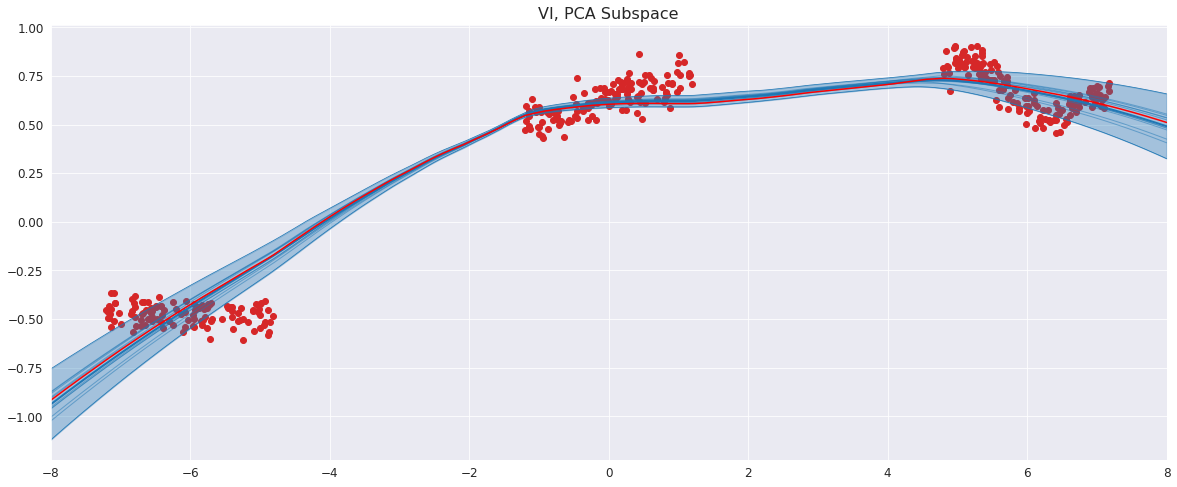

In [ ]:
trajectories = []
np_steps = np.linspace(-8., 8., 1000)
f_steps = features(np_steps)
inp = torch.from_numpy(f_steps.astype(np.float32)).to(device)

vi_model.eval()
with torch.no_grad():
    for i in range(20):
        out = vi_model(inp).cpu().numpy().squeeze()
        trajectories.append(out)
    set_weights(model.parameters(), w_hat)
    out = model(inp).cpu().numpy().squeeze()

trajectories = np.vstack(trajectories)
plot_predictive(trajectories, (x, y), np_steps, title="VI, PCA Subspace")
plt.plot(np_steps, out, color='red')
plt.show()

# Quadratic Bezier Curve Subspace + VI

This provides an example of model failure, using the complicated curve subspace. It is extremely hard to get the initialization conditions correct for this and it relies on two SGD modes which are relatively close to one another.

In [ ]:
endpoints = []
model = MLP(2, 40, 1, 5).to(device)
criterion = nn.MSELoss()
for _ in range(2):
    init_weights(model, 0., 0.25)
    optimizer = torch.optim.Adam(model.parameters())
    train(model, train_iter, val_iter, optimizer, criterion, 1000, device, False)
    print(eval(model, train_iter, criterion, device))
    with torch.no_grad():
        endpoints.append(get_weights(model.parameters()))

curve = QuadraticBezierCurve(*endpoints)

  0%|          | 3/1000 [00:00<00:43, 22.79it/s]

0.0023846960227404323


100%|██████████| 1000/1000 [00:40<00:00, 24.66it/s]

0.0024556635014180627


In [ ]:
subspace = CurveSubspace(model, curve)
subspace_optimizer = torch.optim.Adam(subspace.parameters())
lh = train(subspace, train_iter, val_iter, subspace_optimizer, criterion,
      1000, device, False)

100%|██████████| 1000/1000 [00:35<00:00, 28.23it/s]


In [ ]:
w_hat, subspace_proj = subspace.get_projection()

In [ ]:
init_sigma = 1.
prior_sigma = 5.
vi_model = VIModel(
    base = MLP(2, 40, 1, 5),
    w_hat = w_hat,
    proj_matrix = subspace_proj,
    init_inv_softplus_sigma = np.log(np.exp(init_sigma)-1),
    n_samples=1,
    prior_log_sigma = np.log(prior_sigma)
).to(device)

In [ ]:
elbo = ELBO(vi_model, criterion, len(train_split), temperature=1.5)
optimizer = torch.optim.Adam(vi_model.parameters(), lr=1)
#lh1 = train(vi_model, train_iter, val_iter, optimizer, elbo, 10, device, False, True, 'vi-model.pt')
optimizer = torch.optim.Adam(vi_model.parameters())
lh2 = train(vi_model, train_iter, val_iter, optimizer, elbo, 500, device, False, True, 'vi-model.pt')
lh = lh2#{key: lh1[key] + lh2[key] for key in lh1}

100%|██████████| 500/500 [00:23<00:00, 19.10it/s]


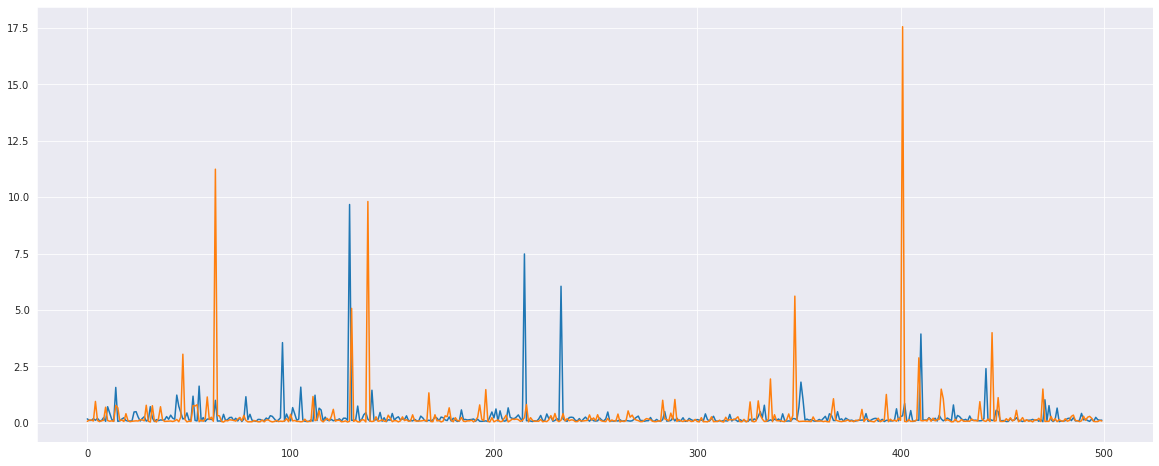

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(lh['train'])
plt.plot(lh['val'])
plt.show()

In [ ]:
point = vi_model.mu.detach().data.cpu().numpy()
l1, l2 = np.mgrid[-1:1:0.1, -1:1:0.1].astype(np.float32) + point[:, None, None]
z = []
model = MLP(2, 40, 1, 5).to(device)
with torch.no_grad():
    for mx, my in zip(l1.flatten(), l2.flatten()):
        w = w_hat + torch.tensor([mx, my], device=device) @ subspace_proj
        set_weights(model.parameters(), w)
        loss = eval(model, train_iter, criterion, device)
        z.append(loss)
z = np.array(z).reshape(*l1.shape)

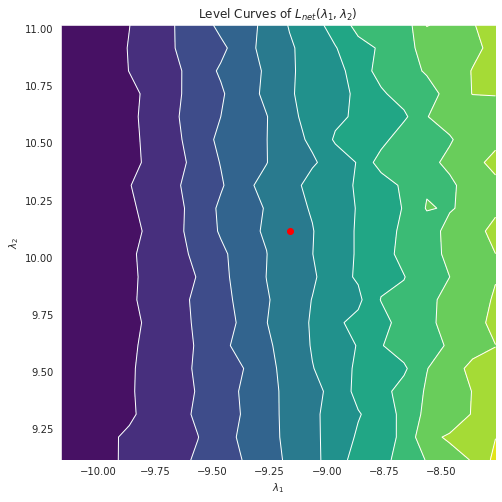

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax.title.set_text("Level Curves of $L_{net}(\lambda_1,\lambda_2)$")
ax.set_xlabel("$\lambda_1$")
ax.set_ylabel("$\lambda_2$")
ax.contourf(l1, l2, z, levels=10, cmap='viridis')
ax.contour(l1, l2, z, linewidths=1, levels=10, colors='white', zorder=1)
ax.set_aspect('equal')
ax.scatter(*point, color='red')
plt.show()

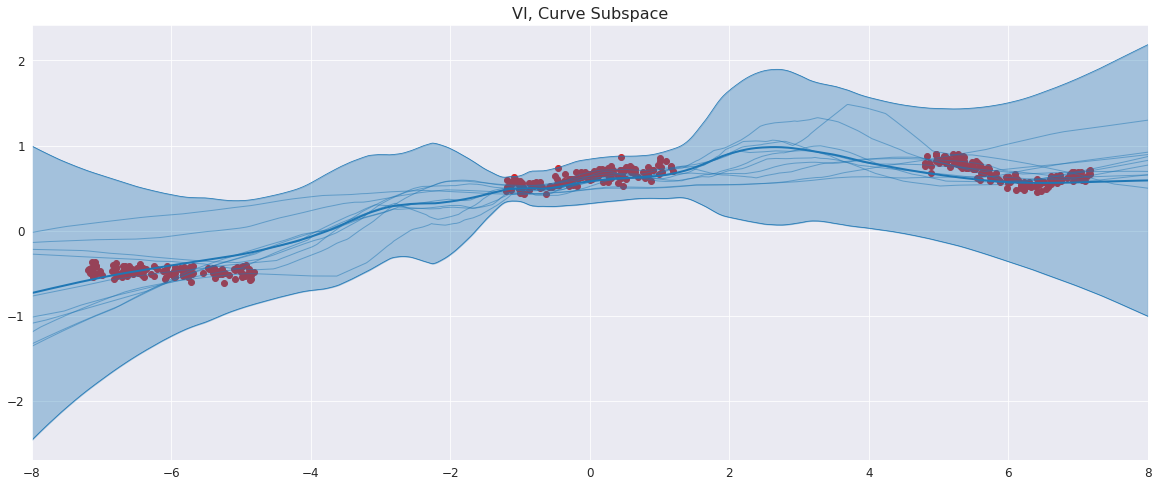

In [ ]:
trajectories = []
np_steps = np.linspace(-8., 8., 1000)
f_steps = features(np_steps)
inp = torch.from_numpy(f_steps.astype(np.float32)).to(device)

vi_model.eval()
with torch.no_grad():
    for i in range(300):
        out = vi_model(inp).cpu().numpy().squeeze()
        trajectories.append(out)

trajectories = np.vstack(trajectories)
plot_predictive(trajectories, (x, y), np_steps, title="VI, Curve Subspace")
plt.show()

# MNIST Dataset

## Setup

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
transform = transforms.ToTensor()

In [ ]:
mnist_train = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
mnist_val = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
mnist_train_iter = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_val_iter = DataLoader(mnist_val, batch_size=64, shuffle=True)

In [ ]:
class LinearModelMNIST(nn.Module):
    def __init__(self, d_height, d_width, d_hidden, d_output, n_layers):
        super().__init__()
        self.mlp = MLP(d_height * d_width, d_hidden, d_output, n_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.mlp(x)

In [ ]:
def test_batch(images, preds, labels=None, n_show=10, n_classes=10):
    for batch_id in range(min(n_show, len(images))):
        if labels is not None:
            print("Real: ", labels[batch_id].item())
        fig, axs = plt.subplots(1, 10, sharey=True, figsize=(20,2))
        for class_id in range(n_classes):
            cur_preds = []
            for traj_id in range(len(preds)):
                cur_preds.append(preds[traj_id][batch_id][class_id])
            N, b, P = axs[class_id].hist(cur_preds, bins=8, range=(0., 1.))
            bin_centers = 0.5 * (b[:-1] + b[1:])
            col = bin_centers - min(bin_centers)
            col /= max(col)
            for n, p in zip(col, P):
                p.set_facecolor(plt.cm.viridis(n))
            axs[class_id].set_xlim(0, 1)
            axs[class_id].set_title(str(class_id))
        plt.show()
        plt.figure(figsize = (1, 1))
        plt.imshow(images[batch_id].squeeze(), cmap='Greys')
        plt.axis('off')
        plt.show()

## SGD Test

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LinearModelMNIST(28, 28, 128, 10, 3).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
model_weights = []
for i in range(5):
    init_weights(model, 0., 0.25)
    train(model, mnist_train_iter, mnist_val_iter, optimizer, criterion, 
          n_epochs=5, device=device, verbose=False, keys=[0,1])
    model_weights.append(get_weights(model.parameters()))

100%|██████████| 5/5 [00:51<00:00, 10.29s/it]


In [ ]:
test_images, test_labels = next(iter(mnist_val_iter))
noise_images = torch.rand_like(test_images)
inp_test = test_images.to(device)
inp_noise = noise_images.to(device)
model.eval()
test_preds = []
noise_preds = []
with torch.no_grad():
    for w in model_weights:
        set_weights(model.parameters(), w)
        out = model(inp_test).softmax(1).cpu().numpy().squeeze()
        test_preds.append(out)
        out = model(inp_noise).softmax(1).cpu().numpy().squeeze()
        noise_preds.append(out)

Real:  7


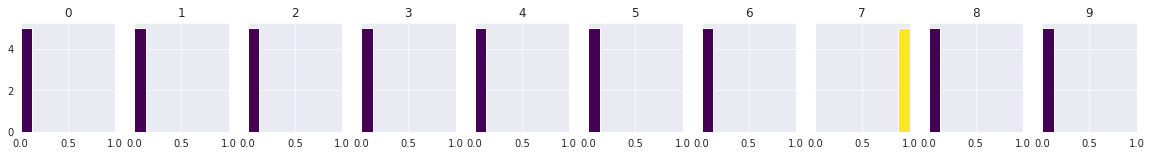

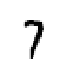

Real:  5


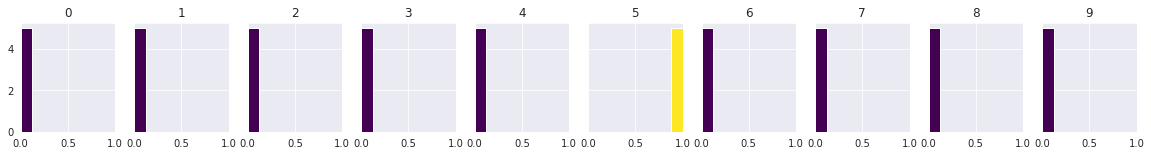

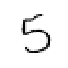

Real:  4


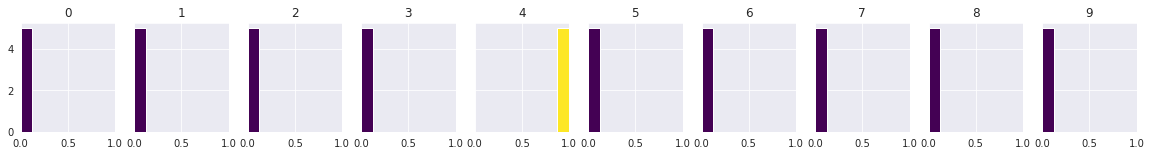

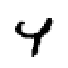

Real:  3


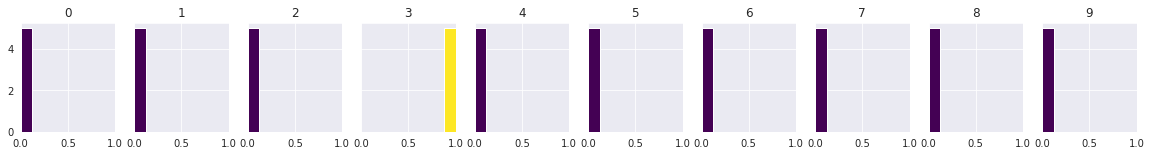

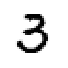

Real:  6


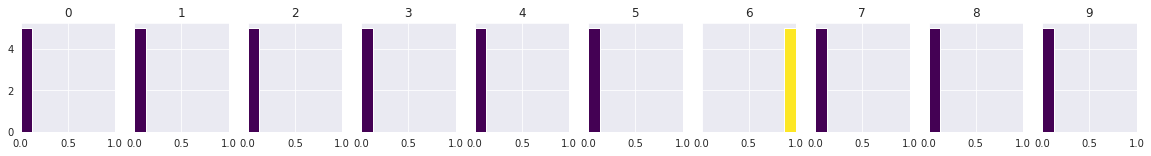

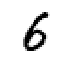

Real:  3


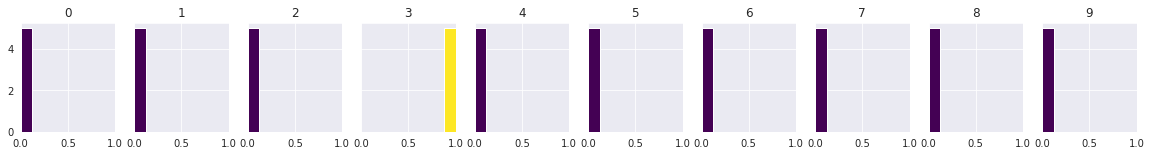

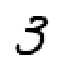

Real:  4


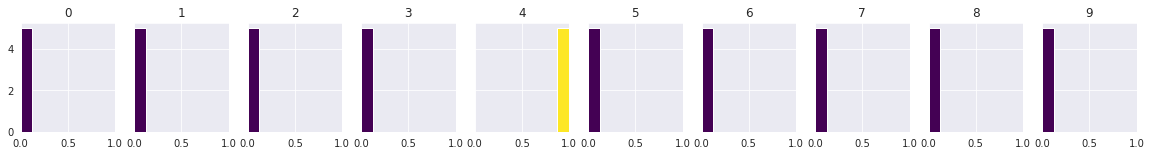

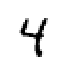

Real:  7


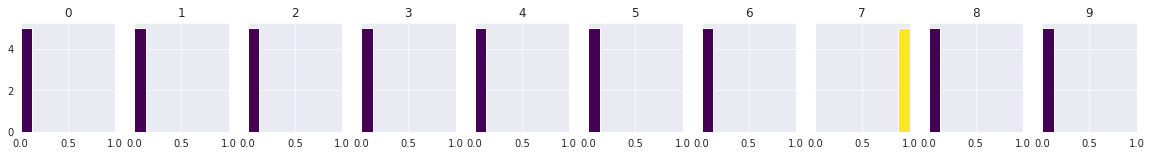

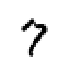

Real:  1


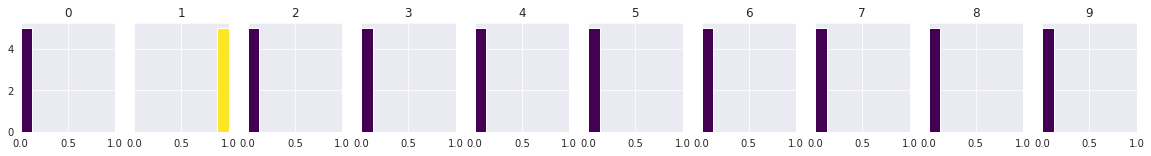

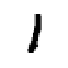

Real:  9


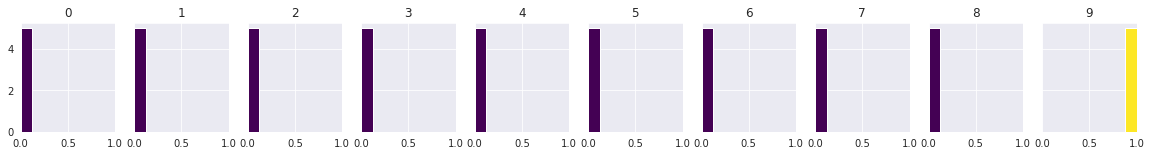

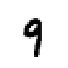

In [ ]:
test_batch(test_images, test_preds, test_labels)

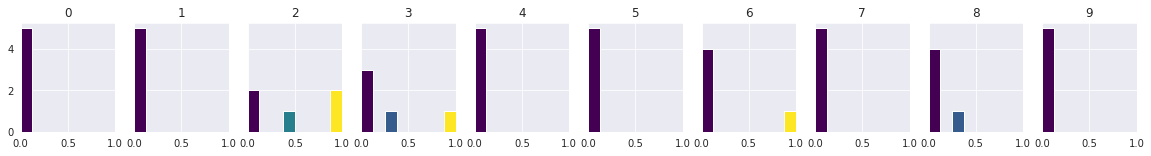

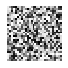

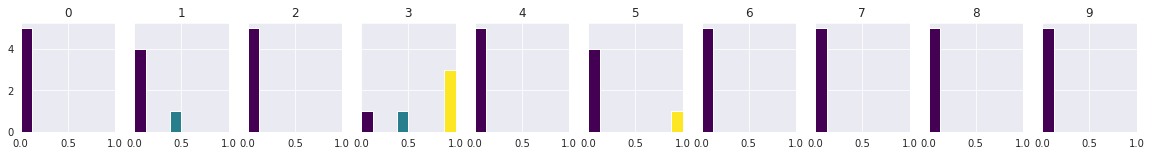

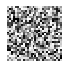

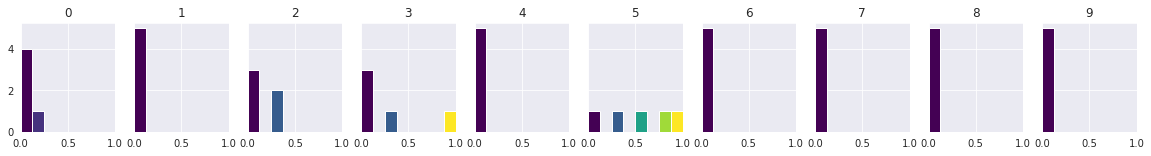

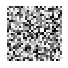

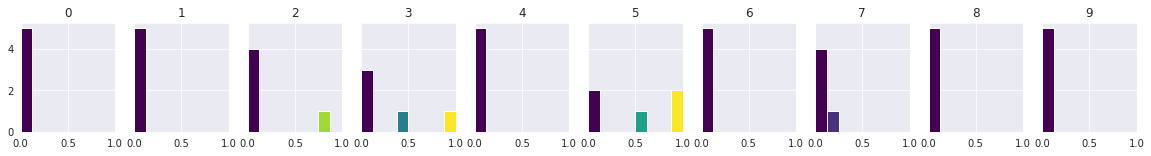

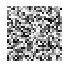

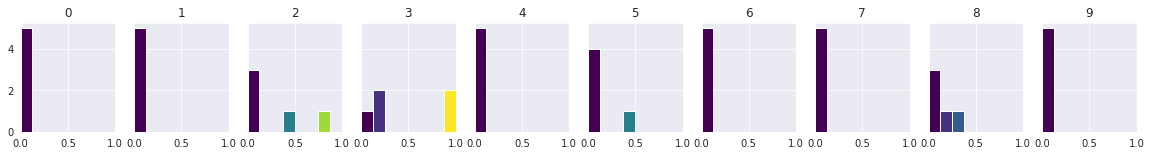

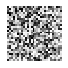

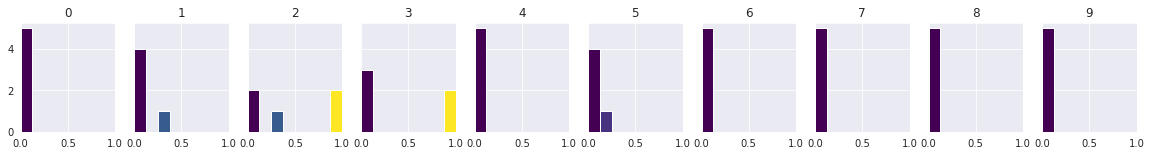

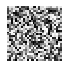

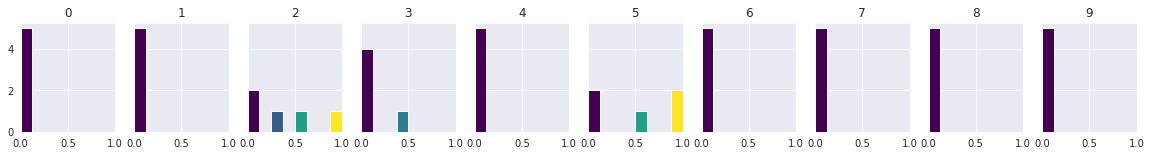

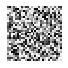

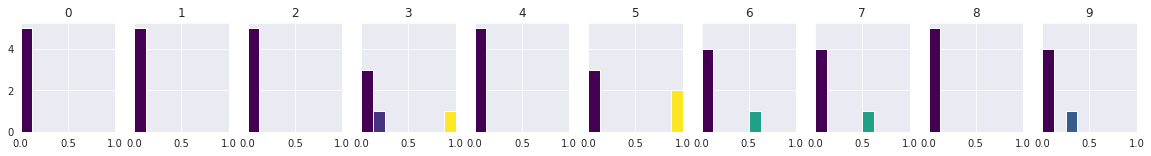

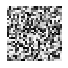

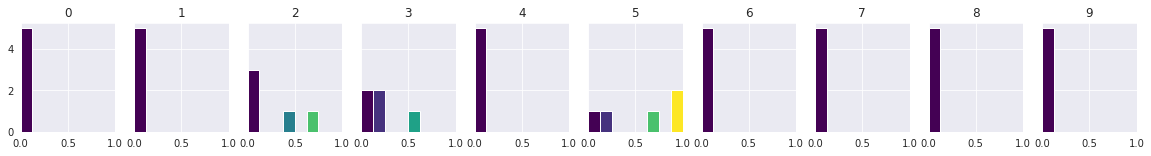

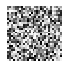

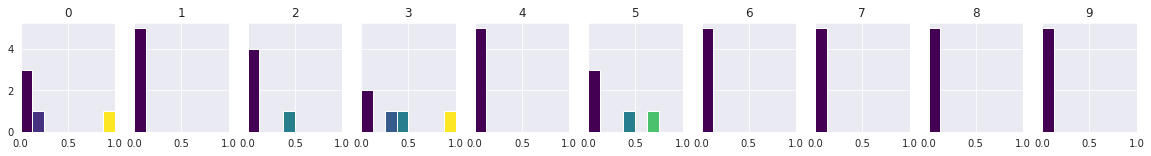

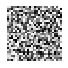

In [ ]:
test_batch(noise_images, noise_preds)

## PCA Subspace

In [ ]:
model = LinearModelMNIST(28, 28, 10, 10, 5).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train(model, mnist_train_iter, mnist_val_iter, optimizer, criterion, 1, device, keys=[0, 1])
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
w_swa, snapshot = snapshot_train(model, mnist_train_iter, optimizer, criterion, 4, 5, 30, device, keys=[0, 1])

Training Model for 1 Epochs
--------------


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 11s
	Train Loss:   0.9911
	 Val. Loss:   0.5229
--------------
Loading model from model.pt with best val. loss   0.5229...


100%|██████████| 4/4 [00:34<00:00,  8.72s/it]


In [ ]:
with torch.no_grad():
    U, S, V = torch.svd(snapshot.cpu())
    proj_matrix = (S * V).t()

In [ ]:
print(f"Initialized and partially trained model with {w_swa.size(0)} parameters.")
print("Dimension Importances")
for v in (S/S.sum()).detach().cpu().numpy()[:10]:
    print(f"{v*100.:5.2f}%")

Initialized and partially trained model with 8290 parameters.
Dimension Importances
86.73%
 2.44%
 1.90%
 1.72%
 1.10%
 0.86%
 0.75%
 0.52%
 0.43%
 0.40%


In [ ]:
subspace_proj = proj_matrix
w_hat = w_swa.detach()

In [ ]:
init_sigma = 1.
prior_sigma = 5.
vi_model = VIModel(
    base = LinearModelMNIST(28, 28, 10, 10, 5),
    w_hat = w_hat,
    proj_matrix = subspace_proj,
    init_inv_softplus_sigma = np.log(np.exp(init_sigma)-1),
    n_samples=5,
    prior_log_sigma = np.log(prior_sigma)
).to(device)

In [ ]:
elbo = ELBO(vi_model, criterion, len(mnist_train), temperature=1.5)
optimizer = torch.optim.Adam(vi_model.parameters())
lh = train(vi_model, mnist_train_iter, mnist_val_iter, optimizer, elbo, 20, device, False, True, 'vi-model.pt', keys=[0, 1])

100%|██████████| 20/20 [06:32<00:00, 19.52s/it]


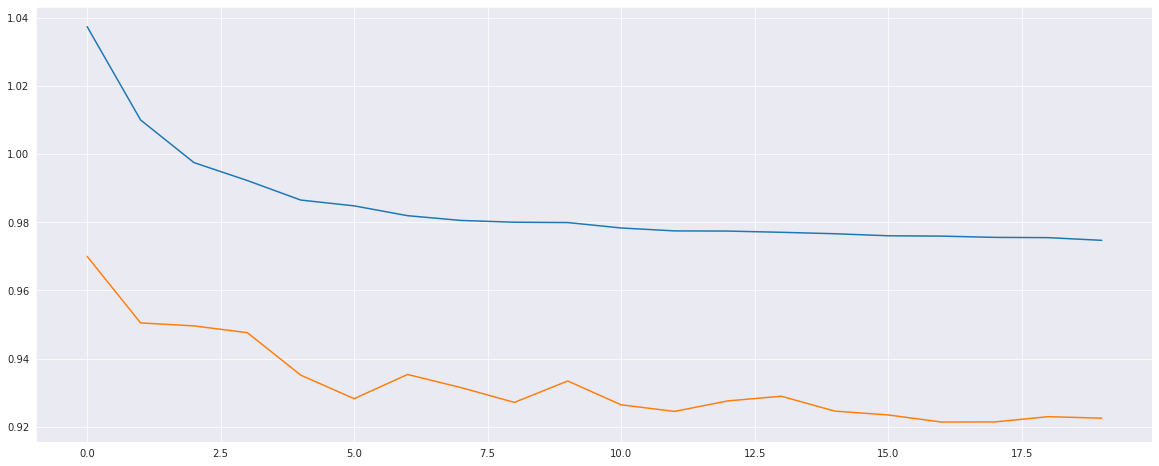

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(lh['train'])
plt.plot(lh['val'])
plt.show()

In [ ]:
inp_test = test_images.to(device)
inp_noise = noise_images.to(device)
vi_model.eval()
test_preds = []
noise_preds = []
with torch.no_grad():
    for _ in range(20):
        out = vi_model(inp_test).softmax(1).cpu().numpy().squeeze()
        test_preds.append(out)
        out = vi_model(inp_noise).softmax(1).cpu().numpy().squeeze()
        noise_preds.append(out)

Real:  7


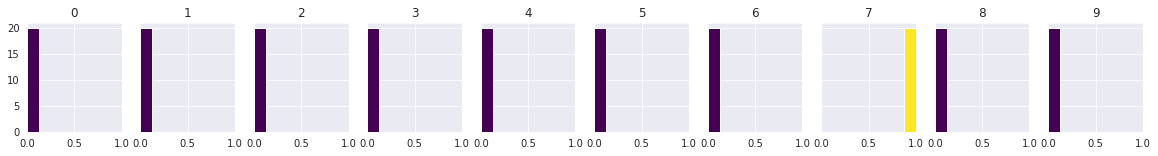

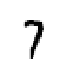

Real:  5


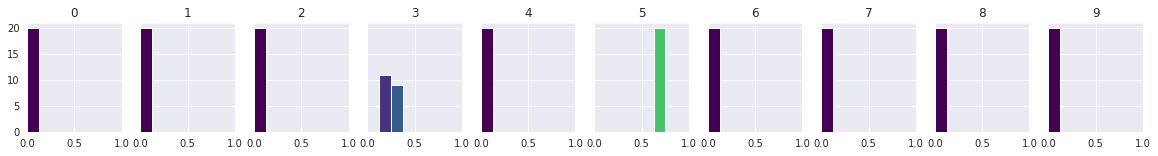

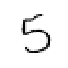

Real:  4


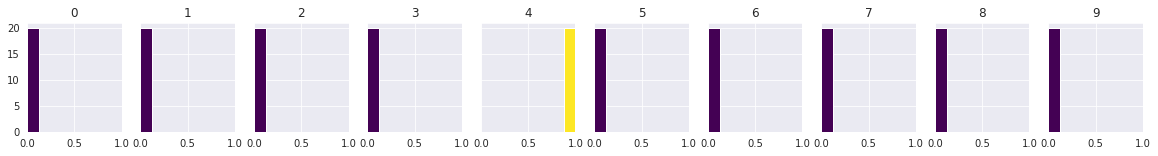

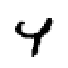

Real:  3


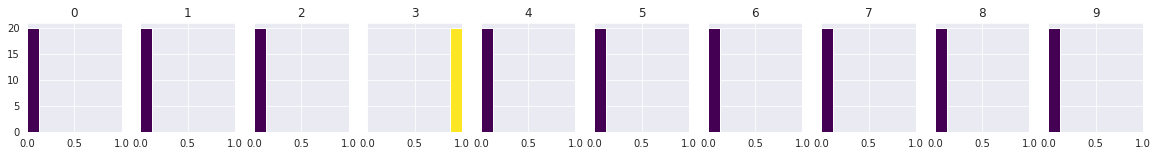

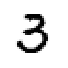

Real:  6


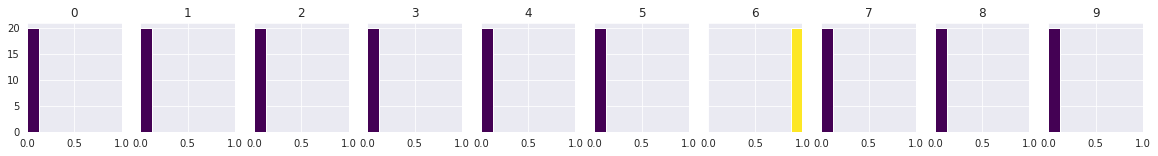

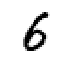

Real:  3


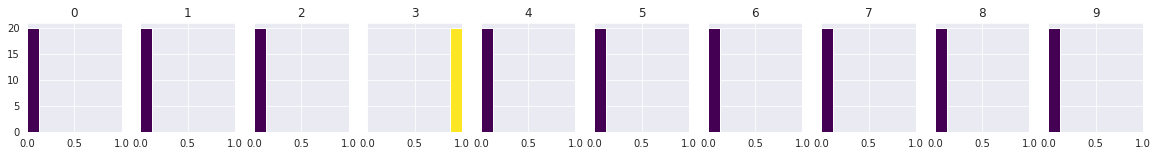

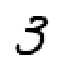

Real:  4


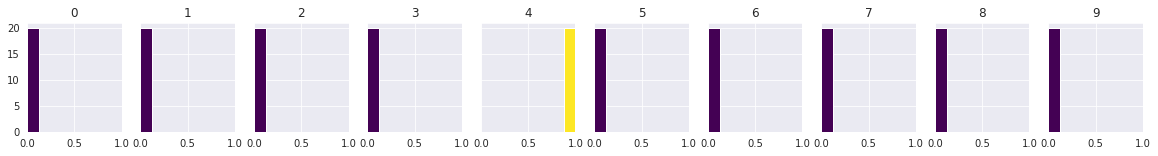

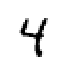

Real:  7


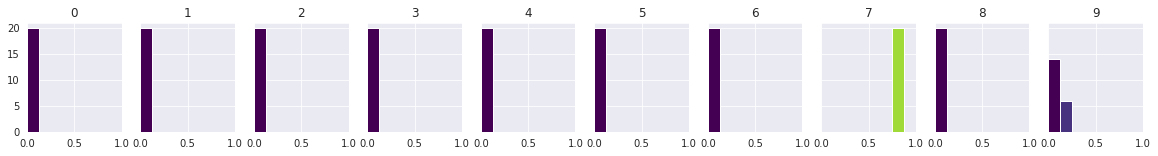

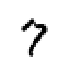

Real:  1


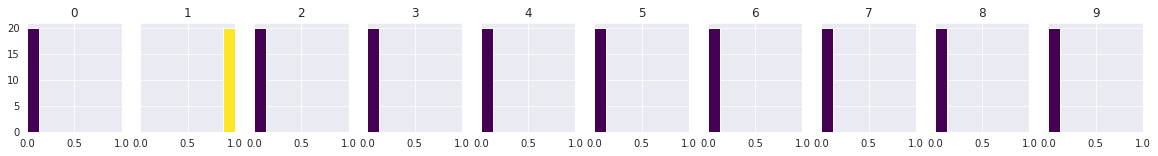

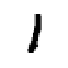

Real:  9


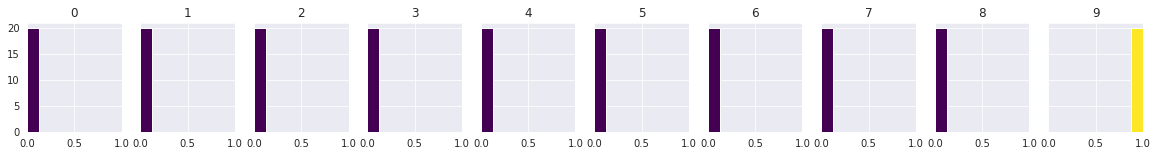

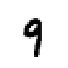

In [ ]:
test_batch(test_images, test_preds, test_labels)

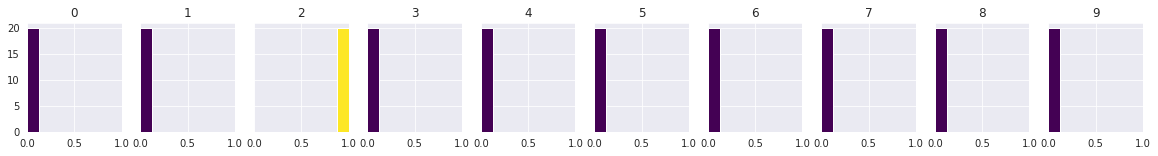

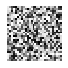

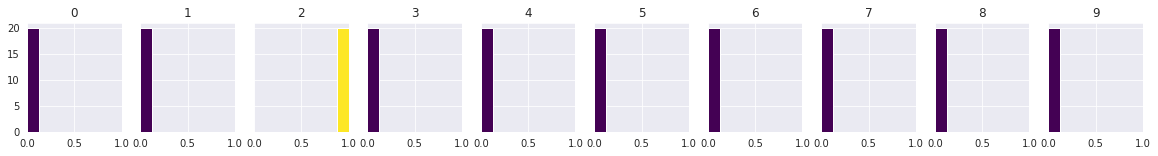

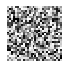

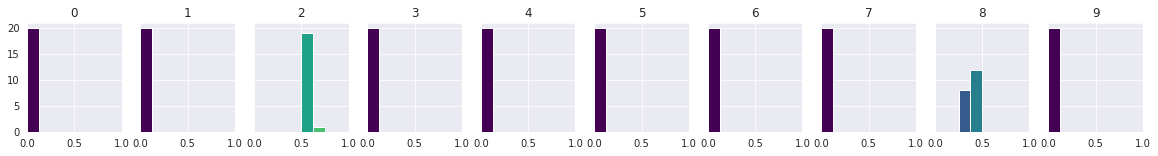

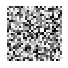

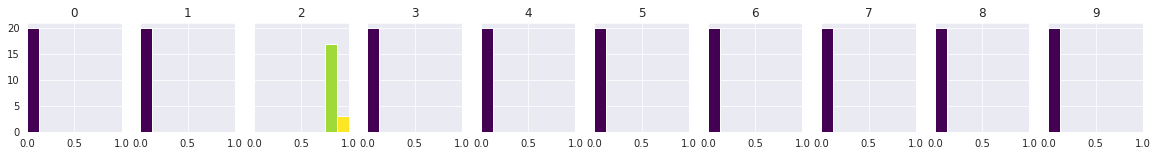

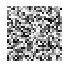

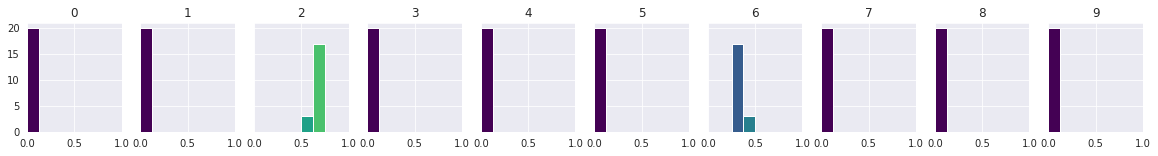

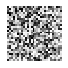

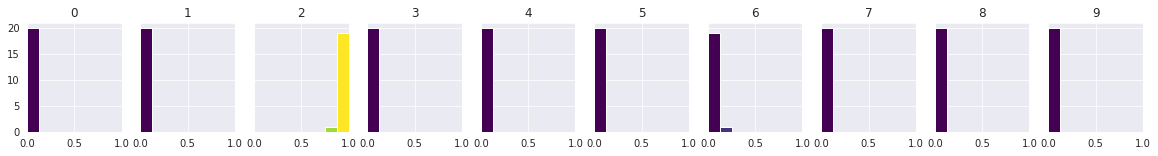

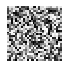

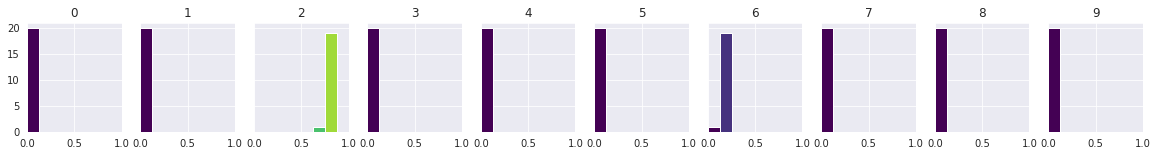

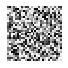

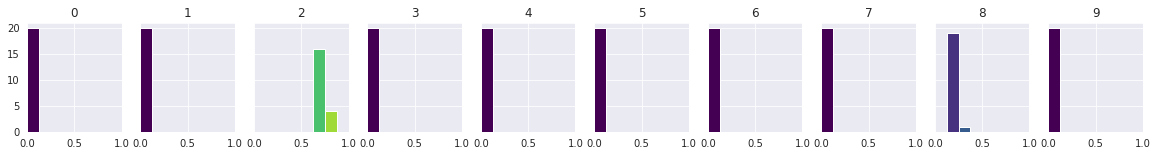

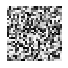

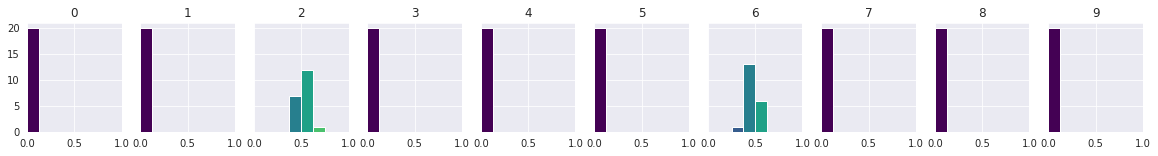

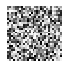

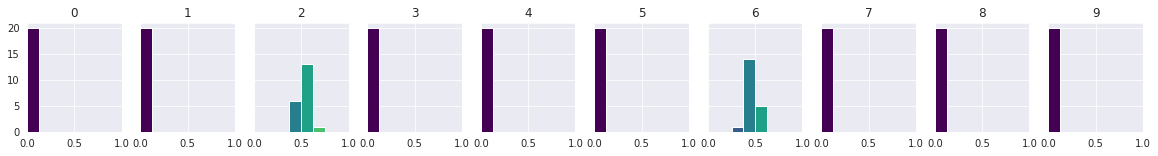

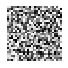

In [ ]:
test_batch(noise_images, noise_preds)

## Curve Subspace

In [ ]:
endpoints = []
model = LinearModelMNIST(28, 28, 10, 10, 5).to(device)
criterion = nn.CrossEntropyLoss()
for _ in range(2):
    init_weights(model, 0., .25)
    optimizer = torch.optim.Adam(model.parameters())
    train(model, mnist_train_iter, mnist_val_iter, optimizer, criterion, 5, device, False, keys=[0, 1])
    with torch.no_grad():
        endpoints.append(get_weights(model.parameters()))
curve = QuadraticBezierCurve(*endpoints)

100%|██████████| 5/5 [01:07<00:00, 13.48s/it]


In [ ]:
model = LinearModelMNIST(28, 28, 10, 10, 5).to(device)
subspace = CurveSubspace(model, curve)
subspace_optimizer = torch.optim.Adam(subspace.parameters())
lh = train(subspace, mnist_train_iter, mnist_val_iter, subspace_optimizer, criterion, 5, device, False, keys=[0, 1])

100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


In [ ]:
w_hat, subspace_proj = subspace.get_projection()

In [ ]:
init_sigma = 1.
prior_sigma = 5.
vi_model = VIModel(
    base = LinearModelMNIST(28, 28, 10, 10, 5),
    w_hat = w_hat,
    proj_matrix = subspace_proj,
    init_inv_softplus_sigma = np.log(np.exp(init_sigma)-1),
    n_samples=1,
    prior_log_sigma = np.log(prior_sigma)
).to(device)

In [ ]:
elbo = ELBO(vi_model, criterion, len(mnist_train), temperature=1.)
optimizer = torch.optim.Adam(vi_model.parameters(), lr=1.)
lh1 = train(vi_model, mnist_train_iter, mnist_val_iter, optimizer, elbo, 5, device, False, True, 'vi-model.pt', keys=[0, 1])
optimizer = torch.optim.Adam(vi_model.parameters())
lh2 = train(vi_model, mnist_train_iter, mnist_val_iter, optimizer, elbo, 20, device, False, True, 'vi-model.pt', keys=[0, 1])
lh = {key: lh1[key] + lh2[key] for key in lh1}

100%|██████████| 20/20 [04:20<00:00, 12.66s/it]


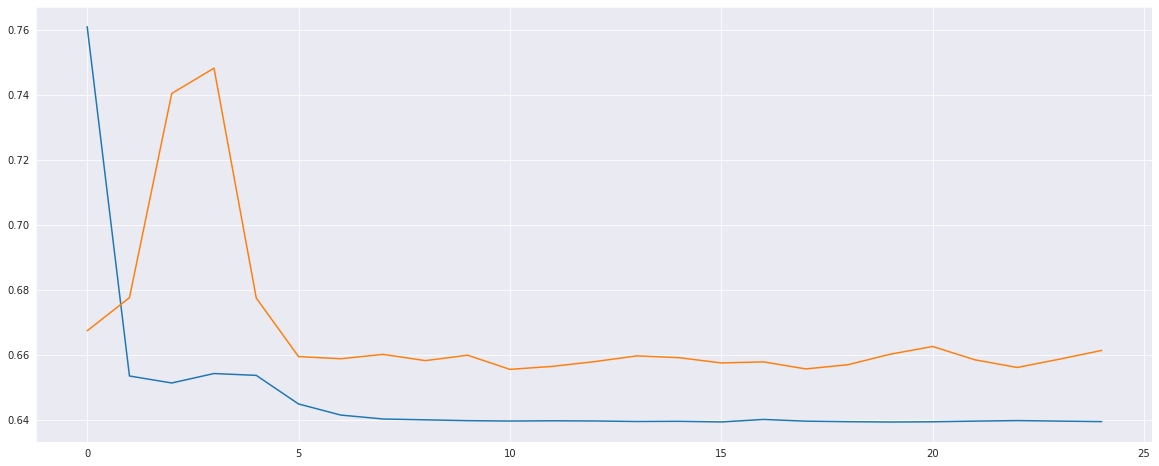

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(lh['train'])
plt.plot(lh['val'])
plt.show()

In [ ]:
point = vi_model.mu.detach().data.cpu().numpy()
l1, l2 = np.mgrid[-1:1:0.1, -1:1:0.1].astype(np.float32) + point[:, None, None]
z = []
model = LinearModelMNIST(28, 28, 10, 10, 5).to(device)
with torch.no_grad():
    for mx, my in zip(l1.flatten(), l2.flatten()):
        w = w_hat + torch.tensor([mx, my], device=device) @ subspace_proj
        set_weights(model.parameters(), w)
        loss = eval(model, mnist_train_iter, criterion, device, src_key=0, trg_key=1)
        z.append(loss)
z = np.array(z).reshape(*l1.shape)

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax.title.set_text("Level Curves of $L_{net}(\lambda_1,\lambda_2)$")
ax.set_xlabel("$\lambda_1$")
ax.set_ylabel("$\lambda_2$")
ax.contourf(l1, l2, z, levels=10, cmap='viridis')
ax.contour(l1, l2, z, linewidths=1, levels=10, colors='white', zorder=1)
ax.set_aspect('equal')
ax.scatter(*point, color='red')
plt.show()

In [ ]:
vi_model.eval()
test_preds = []
noise_preds = []
with torch.no_grad():
    for _ in range(20):
        out = vi_model(inp_test).softmax(1).cpu().numpy().squeeze()
        test_preds.append(out)
        out = vi_model(inp_noise).softmax(1).cpu().numpy().squeeze()
        noise_preds.append(out)

In [ ]:
test_batch(test_images, test_preds, test_labels)

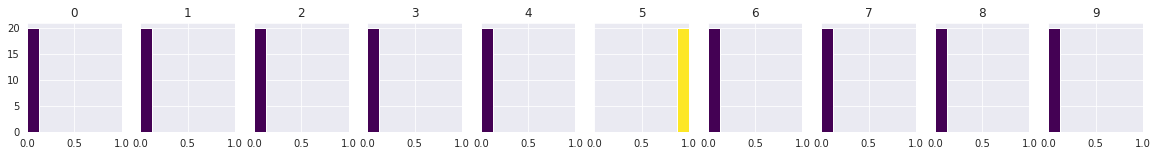

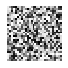

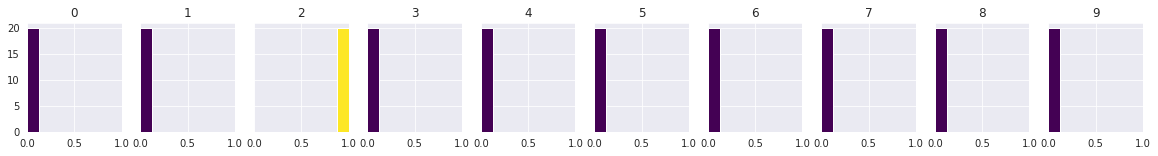

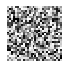

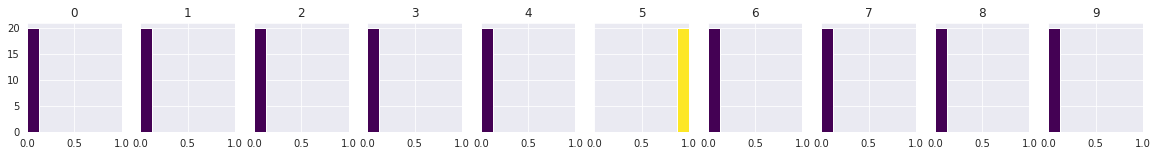

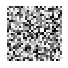

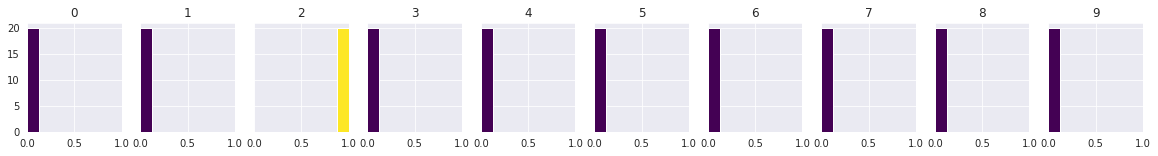

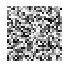

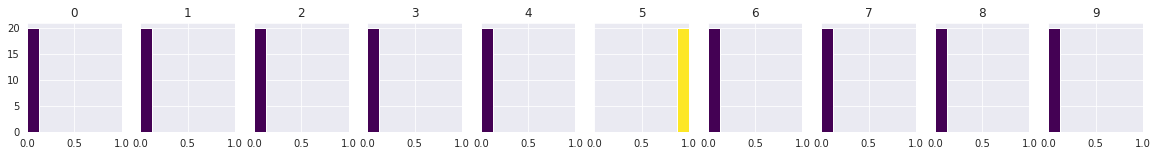

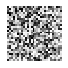

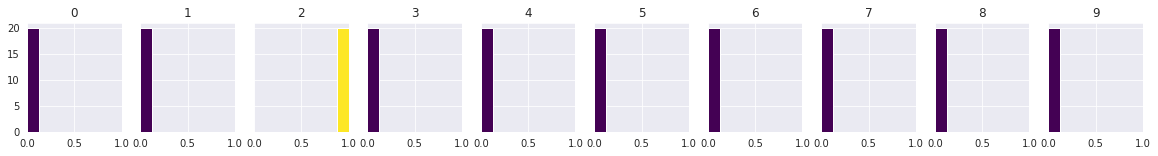

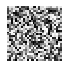

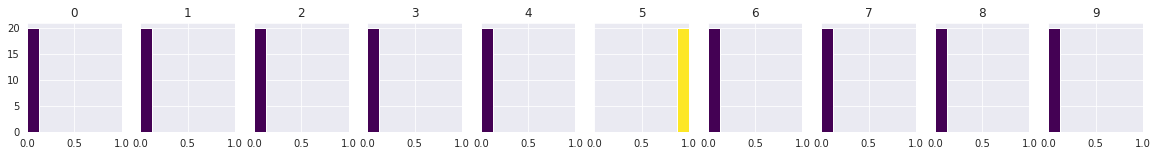

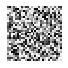

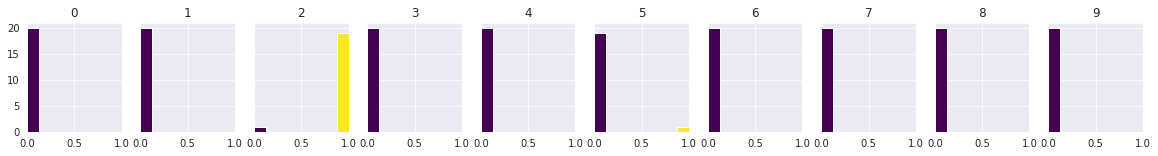

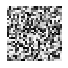

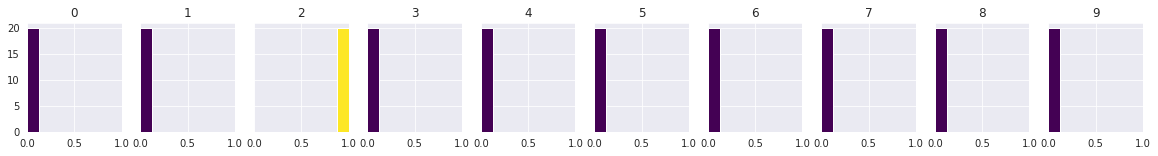

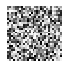

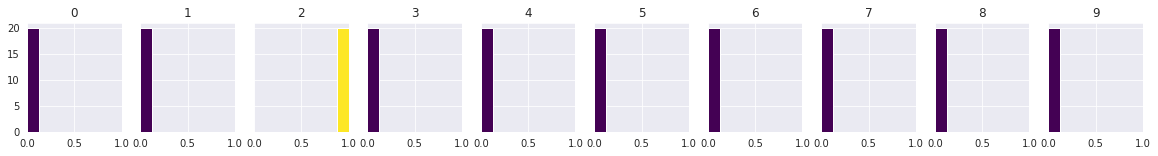

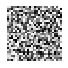

In [ ]:
test_batch(noise_images, noise_preds)